In [1]:
##한겨레 언론사 -> 진보성향
###전체 셀 한번 작동 시키고 런타임 다시 시작한 후에 전체 작동시켜야 한글이 보여요..
!pip install konlpy
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import *
import pandas as pd
from nltk.corpus import stopwords
import konlpy
import re
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#페이지 기사 끌어오기
choice=input('키워드를 입력하세요 : ')
href=[]
for k in range(0,25,1):
    r1=requests.get('https://search.hani.co.kr/Search?command=query&keyword='+choice+'&media=news&submedia=&sort=d&period=all&datefrom=1988.01.01&dateto=2022.05.27&pageseq='+str(k),headers={'User-Agent':'Mozilla/5.0'})
    html1 = r1.text
    
    soup1 = BeautifulSoup(html1,'html.parser')

    titles=soup1.find_all('dt')
    titlelist=[]
    for title in titles:
        titlelist.append(title.get_text())

    div=soup1.find('div',class_='search-result-section first-child')

    h=div.find_all('a')
    for i in h:
        i=i.get('href')
        if i.startswith('/'):
            i='http:'+i
        href.append(i)

키워드를 입력하세요 : 한반도사드


In [3]:
#각 기사 내용 끌어오기
content=[]
for g in href:
    r2=requests.get(g,headers={'User-Agent':'Mozilla/5.0'})
    html2=r2.text

    soup2=BeautifulSoup(html2,'html.parser')

    conts=soup2.find_all('p')

    for cont in conts:
        content.append(str(cont.previous_sibling))


df1=pd.DataFrame(data=content,columns=['text'])

In [4]:
#전처리 및 가중치 계산
def clean_k(documents):
    for i, document in enumerate(documents):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True):
            if word[1] in ['Noun','Adjective']:
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document
    df = pd.read_csv('koreanstop.csv')

    stopwords = df.to_numpy()
    nltk.download('punkt')
    for i,document in enumerate(documents):
        clean_words =[]
        for word in nltk.tokenize.word_tokenize(document):
            if word not in stopwords:
                if len(word)>1:
                    clean_words.append(word)
        documents[i] = ' '.join(clean_words)
    return documents
x_data=df1['text'].to_numpy()
x_data=clean_k(x_data)

from sklearn.feature_extraction.text import TfidfVectorizer
transformer = TfidfVectorizer()
x_data = transformer.fit_transform(x_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#상위 15개 단어 추출
w=transformer.vocabulary_
xnp=x_data.toarray()
dff=pd.DataFrame(data=xnp)
wl=list(w)
a={}
for num in range(len(wl)):
    n=w[wl[num]]
    sum_=np.sum(dff[n].unique())
    a[wl[num]]=round(sum_,3)
diction=sorted(a.items(), key=lambda x: x[1], reverse=True)
result=diction[:15]
v=[]
ind=[]
for d,f in result:
    v.append(f)
    ind.append(d)

In [6]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Text(0.5, 1.0, '한겨례')

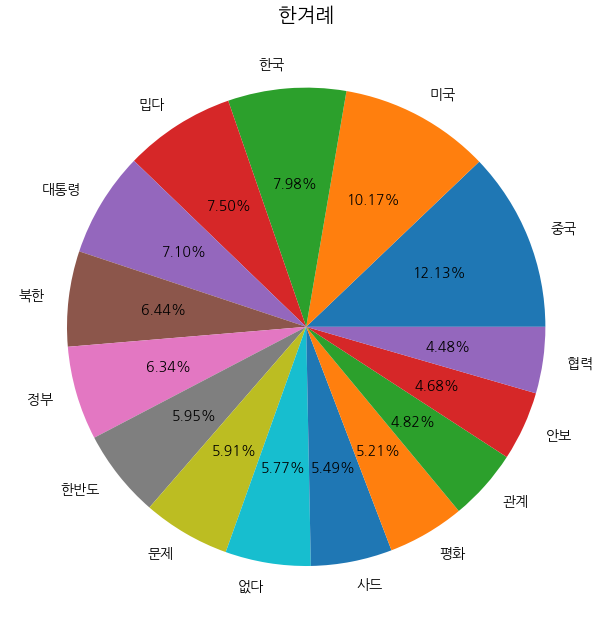

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize']=(11,11)
plt.rcParams['axes.unicode_minus'] = False

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

py=pd.Series(v,index=ind)
ax=plt.subplots()
ax=plt.pie(py, labels=py.index, autopct='%.2f%%',textprops={'fontsize': 14})
plt.title('한겨례',fontsize=20)